In [1]:
import contracts
contracts.disable_all()

In [2]:
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html
import geometry as g
import numpy as np
import networkx as nx
import copy

import sys
sys.path.append("/Users/ossamaahmed/Google Drive/ETHZ/First Semester/Duckietown/repos/duckietown-uplan/lib-uplan/src/duckietown_uplan/")
import graph_utils.augmentation as aug
import graph_utils.segmentify as seg

INFO:dt-world:duckietown-world 1.0.15
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class GenericData
DEBUG:dt-serialization:Registering class Sequence
DEBUG:dt-serialization:Registering class SampledSequence
DEBUG:dt-serialization:Registering class Constant
DEBUG:dt-serialization:Registering class RectangularArea
DEBUG:dt-serialization:Registering class TransformSequence
DEBUG:dt-serialization:Registering class VariableTransformSequence
DEBUG:dt-serialization:Registering class SE2Transform
DEBUG:dt-serialization:Registering class Scale2D
DEBUG:dt-serialization:Registering class Matrix2D
DEBUG:dt-serialization:Registering class SpatialRelation
DEBUG:dt-serialization:Registering class GroundTruth
DEBUG:dt-serialization:Registering class PlacedObject
DEBUG:dt-serialization:Registering class EvaluatedMetric
DEBUG:dt-serialization:Registering class GenericObject
DEBUG:dt-serialization:Registering class Duckie
DEBUG:dt-serialization:Registering cla

In [3]:
dw.logger.setLevel(50)

In [4]:
%%html
<style>
pre {line-height: 90%}
</style>

In [5]:
m = dw.load_map('4way')


In [6]:
sk = seg.get_skeleton_graph(m)


In [7]:
ipython_draw_html(sk.root2);

In [8]:

aug_graph = aug.augment_graph(sk.G, num_right = 1, num_left = 2, dist = 0.05)

In [9]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={}, node_size=10) # node:node for node in G0.nodes()
    nx.draw_networkx_edge_labels(G0,pos,edge_labels={},font_color='red')
    plt.axis('off')
    plt.show()

In [10]:
%matplotlib inline

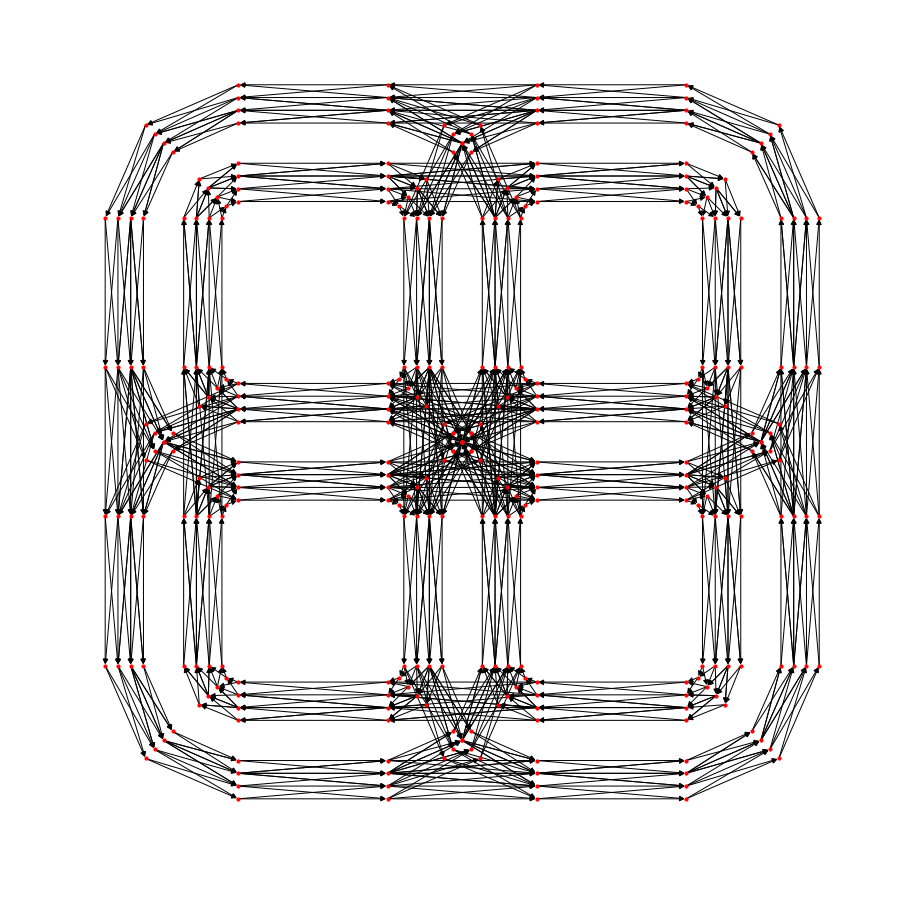

In [11]:
import geometry as geo
pos = {}
for n in aug_graph:
    q = aug_graph.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(aug_graph, pos=pos)

In [12]:
aug_graph.nodes

NodeView(('P0_0', 'P1_0', 'P2_0', 'P3_0', 'P4_0', 'P5_0', 'P6_0', 'P7_0', 'P8_0', 'P9_0', 'P10_0', 'P11_0', 'P12_0', 'P13_0', 'P14_0', 'P15_0', 'P16_0', 'P17_0', 'P18_0', 'P19_0', 'P20_0', 'P21_0', 'P22_0', 'P23_0', 'P24_0', 'P25_0', 'P26_0', 'P27_0', 'P28_0', 'P29_0', 'P30_0', 'P31_0', 'P32_0', 'P33_0', 'P34_0', 'P35_0', 'P36_0', 'P37_0', 'P38_0', 'P39_0', 'P40_0', 'P41_0', 'P42_0', 'P43_0', 'P44_0', 'P45_0', 'P46_0', 'P47_0', 'P48_0', 'P49_0', 'P50_0', 'P51_0', 'P52_0', 'P53_0', 'P54_0', 'P55_0', 'P56_0', 'P57_0', 'P58_0', 'P59_0', 'P60_0', 'P61_0', 'P62_0', 'P63_0', 'P64_0', 'P65_0', 'P66_0', 'P67_0', 'P68_0', 'P69_0', 'P70_0', 'P71_0', 'P72_0', 'P73_0', 'P74_0', 'P75_0', 'P76_0', 'P77_0', 'P78_0', 'P79_0', 'P0_-2', 'P0_-1', 'P0_1', 'P1_-2', 'P1_-1', 'P1_1', 'P2_-2', 'P2_-1', 'P2_1', 'P7_-2', 'P7_-1', 'P7_1', 'P14_-2', 'P14_-1', 'P14_1', 'P17_-2', 'P17_-1', 'P17_1', 'P18_-2', 'P18_-1', 'P18_1', 'P19_-2', 'P19_-1', 'P19_1', 'P27_-2', 'P27_-1', 'P27_1', 'P56_-2', 'P56_-1', 'P56_1', 'P

# BUILD ANOTHER GRAPH

In [13]:
graph_reconstructed = nx.MultiDiGraph()
for node in aug_graph.nodes(data=True):
    node_name = node[0]
    node_info = node[1]
    graph_reconstructed.add_node(node_name, **node_info)
for edge in aug_graph.edges(data=True):
    from_node = edge[0]
    to_node = edge[1]
    edge_info = edge[2]
    graph_reconstructed.add_edge(from_node, to_node, **edge_info)

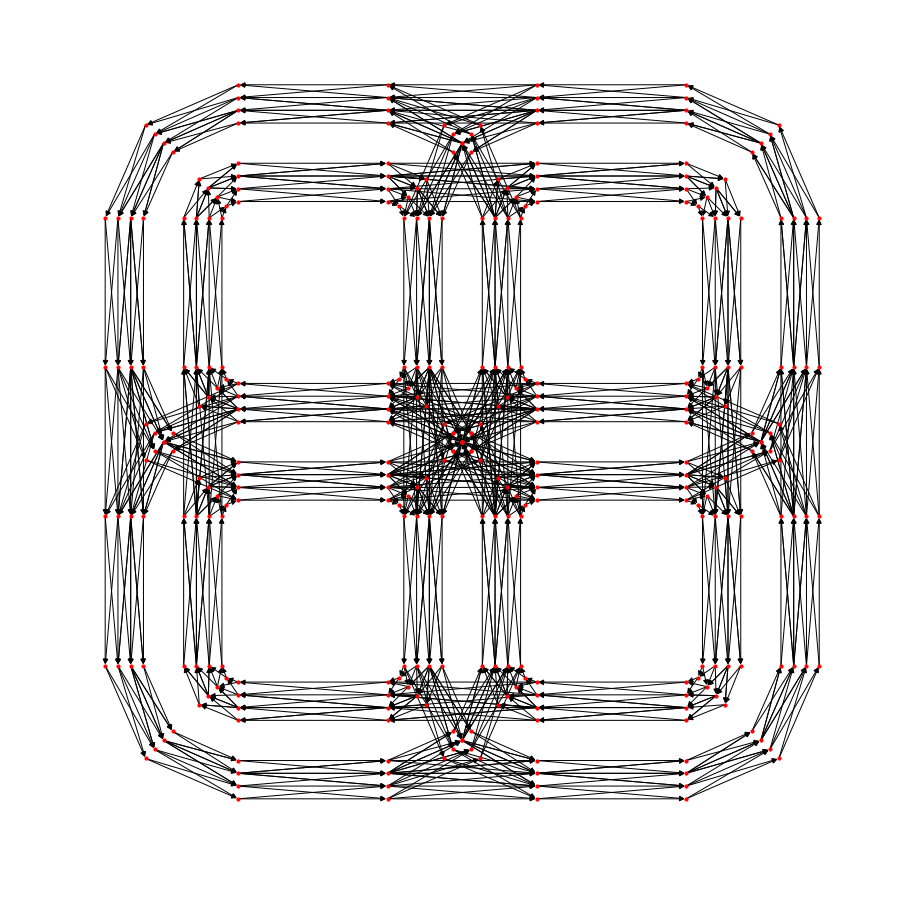

In [14]:
#trying to draw the same graph
import geometry as geo
pos = {}
for n in graph_reconstructed:
    q = graph_reconstructed.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(graph_reconstructed, pos=pos)

# DRAW FIELD OF VIEW

In [15]:
def get_absolute_position_from_graph(graph):
    import geometry as geo
    pos = {}
    for n in graph:
        q = graph.nodes[n]['point'].as_SE2()
        t, _ = geo.translation_angle_from_SE2(q)
        pos[n] = t
    return pos

def draw_two_graphs(first_graph, second_graph=None, my_duckiebot_location=None, other_duckie_bot_locations=[]):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos_first = get_absolute_position_from_graph(first_graph)
    pos_second = get_absolute_position_from_graph(second_graph)
    duckies_graph = nx.MultiDiGraph()
    duckies_graph.add_node('my_duckie_location', point=my_duckiebot_location)
    duckie_counter = 0
    for duckie_location in other_duckie_bot_locations:
        duckies_graph.add_node('duckie_'+str(duckie_counter), point=duckie_location)
        duckie_counter = duckie_counter + 1
    pos_duckies = get_absolute_position_from_graph(duckies_graph)
    plt.figure(figsize=(12, 12))    
    nx.draw(first_graph, pos_first, labels={}, node_size=10, node_color='blue', edge_color='red') # node:node for node in G0.nodes()
    nx.draw(second_graph, pos_second, with_labels=True, node_size=10, node_color='yellow', edge_color='green') # node:node for node in G0.nodes()
    nx.draw(duckies_graph, pos_duckies, with_labels=True, node_size=15, node_color='black') # node:node for node in G0.nodes()
    plt.axis('off')
    plt.show()

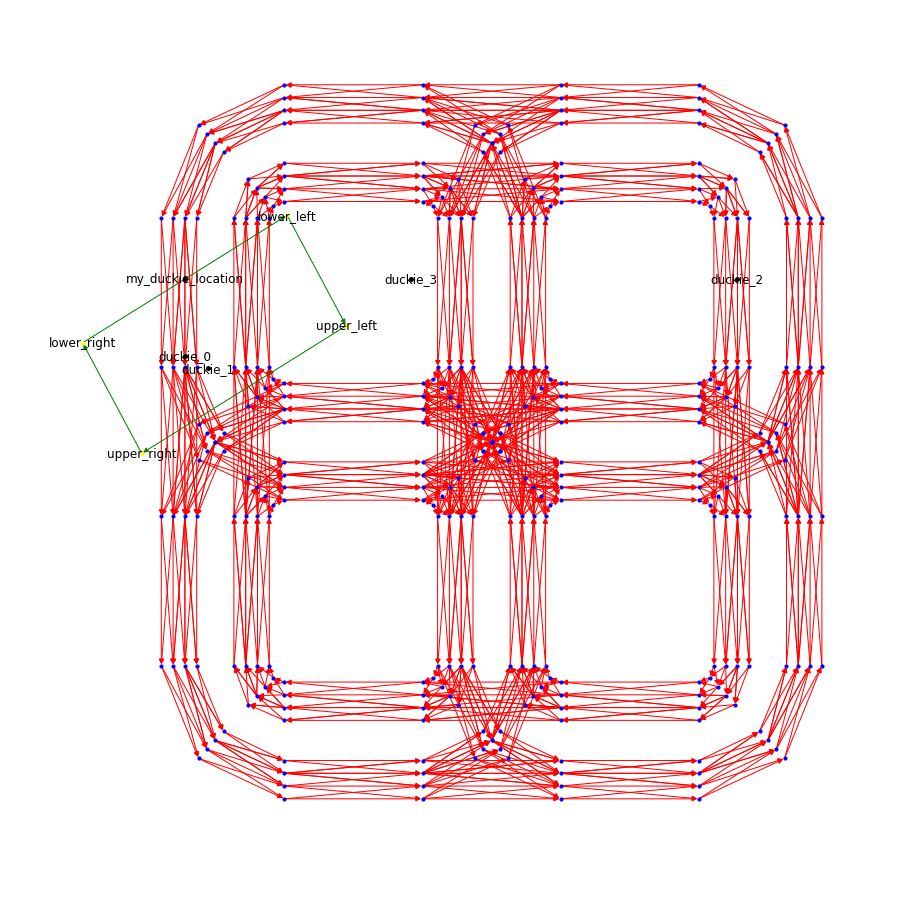

In [16]:
# print(graph_reconstructed.nodes['P54_0']['point'].as_SE2())
# print(graph_reconstructed.nodes['P54_0']['point'])
# t, _ = geo.translation_angle_from_SE2(graph_reconstructed.nodes['P54_0']['point'].as_SE2())
# print(t)
# print(graph_reconstructed.nodes['P55_0']['point'])
from duckietown_world.geo.transforms import SE2Transform

def get_current_duckiebot_location():
    se2_location = SE2Transform([0.16379999399185186, 2.1], -2.61799)
    return se2_location

def get_global_duckiebot_locations():
    duckies = []
    duckie_one =  SE2Transform([0.16379999399185186, 1.8], 0)
    duckie_two =  SE2Transform([0.26, 1.75], -1.61799)
    duckie_three =  SE2Transform([2.5, 2.1], 1.91799)
    duckie_four =  SE2Transform([1.12, 2.1], 1.91799)
    duckies = [duckie_one, duckie_two, duckie_three, duckie_four]
    return duckies

def get_field_of_view_bb(point_SE2, horizontal_limit, vertical_limit):
    #BB ll, lr, ul, ur
    bounding_box = []
    #lower_left
    relative_transform = geo.SE2_from_translation_angle([-horizontal_limit, 0], 0)
    transform = geo.SE2.multiply(point_SE2.as_SE2(), relative_transform)
    bounding_box.append(SE2Transform.from_SE2(transform))
    #lower_right
    relative_transform = geo.SE2_from_translation_angle([horizontal_limit, 0], 0)
    transform = geo.SE2.multiply(point_SE2.as_SE2(), relative_transform)
    bounding_box.append(SE2Transform.from_SE2(transform))
    #upper left
    relative_transform = geo.SE2_from_translation_angle([-horizontal_limit, vertical_limit], 0)
    transform = geo.SE2.multiply(point_SE2.as_SE2(), relative_transform)
    bounding_box.append(SE2Transform.from_SE2(transform))
    #upper right
    relative_transform = geo.SE2_from_translation_angle([horizontal_limit, vertical_limit], 0)
    transform = geo.SE2.multiply(point_SE2.as_SE2(), relative_transform)
    bounding_box.append(SE2Transform.from_SE2(transform))
    #form a graph out of the bounding box ones
    bb_graph = nx.MultiDiGraph()
    bb_graph.add_node('lower_left', point=bounding_box[0])
    bb_graph.add_node('lower_right', point=bounding_box[1])
    bb_graph.add_node('upper_left', point=bounding_box[2])
    bb_graph.add_node('upper_right', point=bounding_box[3])
    bb_graph.add_edge('lower_right', 'lower_left')
    bb_graph.add_edge('lower_left', 'upper_left')
    bb_graph.add_edge('upper_left', 'upper_right')
    bb_graph.add_edge('upper_right', 'lower_right')
    return bounding_box, bb_graph

duckiebot_location = get_current_duckiebot_location()
other_duckies_locs = get_global_duckiebot_locations()
fov, fov_graph = get_field_of_view_bb(duckiebot_location, 0.5, 0.5)
draw_two_graphs(graph_reconstructed, second_graph=fov_graph, my_duckiebot_location=duckiebot_location, other_duckie_bot_locations=other_duckies_locs)

In [17]:
def is_point_in_bounding_box(point_SE2, bb):
    from shapely.geometry import Point
    from shapely.geometry.polygon import Polygon
    point = point_SE2.p
    point = Point(point)
    polygon = Polygon([bb[1].p, bb[0].p, bb[2].p, bb[3].p])
    return polygon.contains(point)  

In [18]:
def get_observed_nodes(graph, bb):
    observed_nodes = []
    for node in graph.nodes(data=True):
        node_data = node[1]
        if is_point_in_bounding_box(node_data['point'], bb):
            observed_nodes.append(node)
    return observed_nodes

In [19]:
current_observed_nodes = get_observed_nodes(graph_reconstructed, fov)

In [20]:
current_observed_nodes

[('P22_0',
  {'point': SE2Transform([0.16379999399185186, 1.754999965429306],-1.5707963267948968),
   'visited': True}),
 ('P23_0',
  {'point': SE2Transform([0.42119998455047614, 1.754999965429306],1.5707963267948963),
   'visited': True}),
 ('P23_-2',
  {'point': SE2Transform([0.5211999773979187, 1.7549999952316284],1.5707963267948963)}),
 ('P23_-1',
  {'point': SE2Transform([0.4711999773979187, 1.7549999952316284],1.5707963267948963)}),
 ('P23_1',
  {'point': SE2Transform([0.3711999773979187, 1.7549999952316284],1.5707963267948963)}),
 ('P22_-2',
  {'point': SE2Transform([0.06380000114440917, 1.7549999952316284],-1.5707963267948968)}),
 ('P22_-1',
  {'point': SE2Transform([0.11380000114440918, 1.7549999952316284],-1.5707963267948968)}),
 ('P22_1',
  {'point': SE2Transform([0.21380000114440917, 1.7549999952316284],-1.5707963267948968)})]

In [21]:
def get_duckiebot_locations_in_current_frame(global_duckies_locations, bb):
    observed_duckies = []
    for duckie_loc in global_duckies_locations:
        if is_point_in_bounding_box(duckie_loc, bb):
            observed_duckies.append(duckie_loc)
    return observed_duckies

In [22]:
current_observed_duckie_locs = get_duckiebot_locations_in_current_frame(other_duckies_locs, fov)

In [23]:
print(current_observed_duckie_locs)

[SE2Transform([0.16379999399185186, 1.8],0.0), SE2Transform([0.26, 1.75],-1.61799)]


# UPDATE UNCERTAINITIES

In [24]:
#THIS NEEDS TO BE MODIFIED TO RETURN A LIST OF NEIGHBORS TO BE BLOCKED
def get_closest_neighbor(graph, node_location):
    closest_node = None
    min_distance = float('inf')
    for neighbor in graph.nodes(data=True):
        neighbor_name = neighbor[0]
        neighbor_location = neighbor[1]['point']
        curr_distance = euclidean_distance(node_location, neighbor_location)
        if curr_distance < min_distance:
            min_distance = curr_distance
            closest_node = neighbor
    return [closest_node], min_distance

def euclidean_distance(node1_SE2, node2_SE2):
    return np.linalg.norm(node1_SE2.p-node2_SE2.p)

In [25]:
get_closest_neighbor(graph_reconstructed, current_observed_duckie_locs[0])

([('P22_0',
   {'point': SE2Transform([0.16379999399185186, 1.754999965429306],-1.5707963267948968),
    'visited': True})],
 0.045000034570694014)

In [26]:
def get_blocked_nodes(graph, current_observed_obstacles):
    blocked_nodes = []
    for obstacle in current_observed_obstacles:
        closest_nodes, _ = get_closest_neighbor(graph, obstacle)
        blocked_nodes.extend(closest_nodes)
    return blocked_nodes

In [27]:
certain_blocked_nodes = get_blocked_nodes(graph_reconstructed, current_observed_duckie_locs)

In [28]:
print(certain_blocked_nodes)

[('P22_0', {'point': SE2Transform([0.16379999399185186, 1.754999965429306],-1.5707963267948968), 'visited': True}), ('P22_1', {'point': SE2Transform([0.21380000114440917, 1.7549999952316284],-1.5707963267948968)})]


In [29]:
import collections
observation_memory_length = 15
initial_obstacle_prob = 0.2

observed_nodes_history = collections.deque(maxlen=observation_memory_length)

def update_observed_nodes_history(fov):
    current_observed_nodes = get_observed_nodes(graph_reconstructed, fov)
    observed_nodes_history.append(current_observed_nodes)
    
def build_obstacle_uncertainity(graph, initial_obstacle_prob=0.2):
    obstacle_uncertainities = {}
    for node in graph.nodes(data=True):
        node_name = node[0]
        obstacle_uncertainities[node_name] = initial_obstacle_prob
    return obstacle_uncertainities

def update_obstacle_uncertainity(graph, current_obstacle_uncertainities, current_observed_obstacles, 
                                 current_observed_nodes, discount_factor=0.8):
    current_certain_obstacles = get_blocked_nodes(graph, current_observed_obstacles)
    #block the certain ones now and clear the other observed nodes
    #get the names only of the nodes that we care about for now
    current_certain_obstacles_indicies = [blocked_node[0] for blocked_node in current_certain_obstacles]
    current_observed_nodes_indicies = [observed_node[0] for observed_node in current_observed_nodes]
    #now loop on all the nodes that I can see now
    for current_observed_node in current_observed_nodes_indicies:
        if current_observed_node in current_certain_obstacles_indicies:   
            current_obstacle_uncertainities[current_observed_node] = 1
        else:
            current_obstacle_uncertainities[current_observed_node] = 0
    #now we need to update the uncertainities for the last t steps from the observed_nodes_history if not observed
    for timestep in observed_nodes_history:
        for node in timestep:
            #get its name
            node_name = node[0]
            if node_name in current_observed_nodes_indicies:
                continue
            #reduce it if its higher than the initial obstacle prob and increase otherwise
            if current_obstacle_uncertainities[node_name] > initial_obstacle_prob:
                current_obstacle_uncertainities[node_name] = current_obstacle_uncertainities[node_name] * discount_factor
            elif current_obstacle_uncertainities[node_name] < initial_obstacle_prob:
                current_obstacle_uncertainities[node_name] = current_obstacle_uncertainities[node_name] + (initial_obstacle_prob / observation_memory_length)
            else:
                continue
    return current_obstacle_uncertainities

In [30]:
obstacle_uncertainities = build_obstacle_uncertainity(graph_reconstructed, initial_obstacle_prob=0.2)

In [31]:
print(obstacle_uncertainities)

{'P0_0': 0.2, 'P1_0': 0.2, 'P2_0': 0.2, 'P3_0': 0.2, 'P4_0': 0.2, 'P5_0': 0.2, 'P6_0': 0.2, 'P7_0': 0.2, 'P8_0': 0.2, 'P9_0': 0.2, 'P10_0': 0.2, 'P11_0': 0.2, 'P12_0': 0.2, 'P13_0': 0.2, 'P14_0': 0.2, 'P15_0': 0.2, 'P16_0': 0.2, 'P17_0': 0.2, 'P18_0': 0.2, 'P19_0': 0.2, 'P20_0': 0.2, 'P21_0': 0.2, 'P22_0': 0.2, 'P23_0': 0.2, 'P24_0': 0.2, 'P25_0': 0.2, 'P26_0': 0.2, 'P27_0': 0.2, 'P28_0': 0.2, 'P29_0': 0.2, 'P30_0': 0.2, 'P31_0': 0.2, 'P32_0': 0.2, 'P33_0': 0.2, 'P34_0': 0.2, 'P35_0': 0.2, 'P36_0': 0.2, 'P37_0': 0.2, 'P38_0': 0.2, 'P39_0': 0.2, 'P40_0': 0.2, 'P41_0': 0.2, 'P42_0': 0.2, 'P43_0': 0.2, 'P44_0': 0.2, 'P45_0': 0.2, 'P46_0': 0.2, 'P47_0': 0.2, 'P48_0': 0.2, 'P49_0': 0.2, 'P50_0': 0.2, 'P51_0': 0.2, 'P52_0': 0.2, 'P53_0': 0.2, 'P54_0': 0.2, 'P55_0': 0.2, 'P56_0': 0.2, 'P57_0': 0.2, 'P58_0': 0.2, 'P59_0': 0.2, 'P60_0': 0.2, 'P61_0': 0.2, 'P62_0': 0.2, 'P63_0': 0.2, 'P64_0': 0.2, 'P65_0': 0.2, 'P66_0': 0.2, 'P67_0': 0.2, 'P68_0': 0.2, 'P69_0': 0.2, 'P70_0': 0.2, 'P71_0': 0.2, '

In [32]:
obstacle_uncertainities = update_obstacle_uncertainity(graph_reconstructed, obstacle_uncertainities, current_observed_duckie_locs, 
                                                       current_observed_nodes, discount_factor=0.8)
update_observed_nodes_history(fov)
print(obstacle_uncertainities)


{'P0_0': 0.2, 'P1_0': 0.2, 'P2_0': 0.2, 'P3_0': 0.2, 'P4_0': 0.2, 'P5_0': 0.2, 'P6_0': 0.2, 'P7_0': 0.2, 'P8_0': 0.2, 'P9_0': 0.2, 'P10_0': 0.2, 'P11_0': 0.2, 'P12_0': 0.2, 'P13_0': 0.2, 'P14_0': 0.2, 'P15_0': 0.2, 'P16_0': 0.2, 'P17_0': 0.2, 'P18_0': 0.2, 'P19_0': 0.2, 'P20_0': 0.2, 'P21_0': 0.2, 'P22_0': 1, 'P23_0': 0, 'P24_0': 0.2, 'P25_0': 0.2, 'P26_0': 0.2, 'P27_0': 0.2, 'P28_0': 0.2, 'P29_0': 0.2, 'P30_0': 0.2, 'P31_0': 0.2, 'P32_0': 0.2, 'P33_0': 0.2, 'P34_0': 0.2, 'P35_0': 0.2, 'P36_0': 0.2, 'P37_0': 0.2, 'P38_0': 0.2, 'P39_0': 0.2, 'P40_0': 0.2, 'P41_0': 0.2, 'P42_0': 0.2, 'P43_0': 0.2, 'P44_0': 0.2, 'P45_0': 0.2, 'P46_0': 0.2, 'P47_0': 0.2, 'P48_0': 0.2, 'P49_0': 0.2, 'P50_0': 0.2, 'P51_0': 0.2, 'P52_0': 0.2, 'P53_0': 0.2, 'P54_0': 0.2, 'P55_0': 0.2, 'P56_0': 0.2, 'P57_0': 0.2, 'P58_0': 0.2, 'P59_0': 0.2, 'P60_0': 0.2, 'P61_0': 0.2, 'P62_0': 0.2, 'P63_0': 0.2, 'P64_0': 0.2, 'P65_0': 0.2, 'P66_0': 0.2, 'P67_0': 0.2, 'P68_0': 0.2, 'P69_0': 0.2, 'P70_0': 0.2, 'P71_0': 0.2, 'P72_

In [33]:
current_observed_nodes

[('P22_0',
  {'point': SE2Transform([0.16379999399185186, 1.754999965429306],-1.5707963267948968),
   'visited': True}),
 ('P23_0',
  {'point': SE2Transform([0.42119998455047614, 1.754999965429306],1.5707963267948963),
   'visited': True}),
 ('P23_-2',
  {'point': SE2Transform([0.5211999773979187, 1.7549999952316284],1.5707963267948963)}),
 ('P23_-1',
  {'point': SE2Transform([0.4711999773979187, 1.7549999952316284],1.5707963267948963)}),
 ('P23_1',
  {'point': SE2Transform([0.3711999773979187, 1.7549999952316284],1.5707963267948963)}),
 ('P22_-2',
  {'point': SE2Transform([0.06380000114440917, 1.7549999952316284],-1.5707963267948968)}),
 ('P22_-1',
  {'point': SE2Transform([0.11380000114440918, 1.7549999952316284],-1.5707963267948968)}),
 ('P22_1',
  {'point': SE2Transform([0.21380000114440917, 1.7549999952316284],-1.5707963267948968)})]

In [34]:
obstacle_uncertainities['P22_1']

1

In [35]:
#IMPLEMENT HERE A SIMULATION MOVE DUCKIEBOT FUNCTION


# SHORTEST PATH PLAN

In [36]:
closest_node_to_my_duckie, _ = get_closest_neighbor(graph_reconstructed, duckiebot_location)
start = closest_node_to_my_duckie[0][0]
end = 'P0_-2'

In [37]:
start

'P5_0'

In [38]:
path = nx.shortest_path(graph_reconstructed, start, end)

In [39]:
path

['P5_0',
 'P22_0',
 'P29_0',
 'P30_0',
 'P37_0',
 'P38_0',
 'P39_0',
 'P60_0',
 'P73_0',
 'P69_-1',
 'P64_-2',
 'P65_-2',
 'P59_-2',
 'P34_-2',
 'P23_-2',
 'P0_-2']

In [40]:
# def get_lanes(path, graph_G):
#     edges = zip(path[:-1], path[1:]) 
#     lanes  = []
#     for a, b in edges:
#         lane = graph_G.get_edge_data(a, b)[0]['lane']
#         lanes.append(lane)
#     return lanes

In [41]:
# lanes = get_lanes(path, graph_reconstructed);
# print(lanes)

# ADD VISUALIZATION FOR THE SHORTEST PATH

In [42]:
def cost_function():
    import random as rn
    return rn.randint(0,10)

In [43]:
def velocity_profiler(path, G):
    import networkx as nx
    import numpy as np
    
    vel_G = nx.DiGraph()
    vel_min = 0.1
    vel_max = 0.5
    vel_space = np.linspace(vel_min, vel_max, 5)
    
    vel_G.add_node((1,1));
    
    for i in range(len(path)-1):
        for j, vel in enumerate(vel_space):
            vel_G.add_node((i+2, j+1))
        
    for (i,j) in vel_G:
        if i==1:
            for k, vel in enumerate(vel_space):
                vel_G.add_edge((1,1),(2,k+1), weight = cost_function())
        elif i<len(path):
            for k, vel in enumerate(vel_space):
                vel_G.add_edge((i,j),(i+1,k+1), weight = cost_function())
            
    return vel_G

In [44]:
vel_G = velocity_profiler(path, aug_graph)

In [45]:
vel_path = nx.astar_path(vel_G, (1, 1), (len(path), 2), heuristic=None, weight='weight')

In [46]:
import numpy as np

In [47]:
vel_min = 0.1
vel_max = 0.5
vel_space = np.linspace(vel_min, vel_max, 5)

In [48]:
for k, node in enumerate(vel_path):
    print('k: {}, node: {}, velocity: {}'.format(k, node, vel_space[node[1]-1]))

k: 0, node: (1, 1), velocity: 0.1
k: 1, node: (2, 3), velocity: 0.30000000000000004
k: 2, node: (3, 3), velocity: 0.30000000000000004
k: 3, node: (4, 1), velocity: 0.1
k: 4, node: (5, 4), velocity: 0.4
k: 5, node: (6, 4), velocity: 0.4
k: 6, node: (7, 2), velocity: 0.2
k: 7, node: (8, 2), velocity: 0.2
k: 8, node: (9, 1), velocity: 0.1
k: 9, node: (10, 2), velocity: 0.2
k: 10, node: (11, 2), velocity: 0.2
k: 11, node: (12, 5), velocity: 0.5
k: 12, node: (13, 3), velocity: 0.30000000000000004
k: 13, node: (14, 2), velocity: 0.2
k: 14, node: (15, 5), velocity: 0.5
k: 15, node: (16, 2), velocity: 0.2
